In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import tree 


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Preprocessing

## Importing Team Stats Dataset

In [2]:
#Importing Raw Data
df= pd.read_csv('eplmatches.csv')
df

,Season_End_Year,Wk,Date,Home,HomeGoals,AwayGoals,Away,FTR
0,1993,1,1992-08-15,Coventry City,2,1,Middlesbrough,H
1,1993,1,1992-08-15,Leeds United,2,1,Wimbledon,H
2,1993,1,1992-08-15,Sheffield Utd,2,1,Manchester Utd,H
3,1993,1,1992-08-15,Crystal Palace,3,3,Blackburn,D
4,1993,1,1992-08-15,Arsenal,2,4,Norwich City,A
...,...,...,...,...,...,...,...,...
11641,2022,9,2021-10-23,Leeds United,1,1,Wolves,D
11642,2022,9,2021-10-23,Brighton,1,4,Manchester City,A
11643,2022,9,2021-10-24,West Ham,1,0,Tottenham,H
11644,2022,9,2021-10-24,Brentford,1,2,Leicester City,A


In [3]:
df.Home.unique()

array(['Coventry City', 'Leeds United', 'Sheffield Utd', 'Crystal Palace',
       'Arsenal', 'Ipswich Town', 'Everton', 'Southampton', 'Chelsea',
       "Nott'ham Forest", 'Manchester City', 'Blackburn',
       'Manchester Utd', 'Liverpool', 'Middlesbrough', 'Sheffield Weds',
       'Wimbledon', 'QPR', 'Oldham Athletic', 'Tottenham', 'Norwich City',
       'Aston Villa', 'Newcastle Utd', 'West Ham', 'Swindon Town',
       'Leicester City', 'Bolton', 'Sunderland', 'Derby County',
       'Barnsley', 'Charlton Ath', 'Watford', 'Bradford City', 'Fulham',
       'West Brom', 'Birmingham City', 'Portsmouth', 'Wolves',
       'Wigan Athletic', 'Reading', 'Hull City', 'Stoke City', 'Burnley',
       'Blackpool', 'Swansea City', 'Cardiff City', 'Bournemouth',
       'Brighton', 'Huddersfield', 'Brentford'], dtype=object)

In [4]:
#Adding (Won,Lost,HomeDraws,AwayDraws) Columns
df.loc[df['FTR'] =='H', 'Won'] = df['Home']
df.loc[df['FTR'] =='A', 'Won'] = df['Away']
df.loc[df['FTR'] =='H', 'Lost'] =df['Away']
df.loc[df['FTR'] =='A', 'Lost'] =df['Home']
df.loc[df['FTR'] =='D', 'HomeDraw'] = df['Home']
df.loc[df['FTR'] =='D', 'AwayDraw'] = df['Away']

In [5]:
df=df[df.Wk<20] # Getting only the games till the mid-season
"""with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)"""
df

,Season_End_Year,Wk,Date,Home,HomeGoals,AwayGoals,Away,FTR,Won,Lost,HomeDraw,AwayDraw
0,1993,1,1992-08-15,Coventry City,2,1,Middlesbrough,H,Coventry City,Middlesbrough,NaN,NaN
1,1993,1,1992-08-15,Leeds United,2,1,Wimbledon,H,Leeds United,Wimbledon,NaN,NaN
2,1993,1,1992-08-15,Sheffield Utd,2,1,Manchester Utd,H,Sheffield Utd,Manchester Utd,NaN,NaN
3,1993,1,1992-08-15,Crystal Palace,3,3,Blackburn,D,NaN,NaN,Crystal Palace,Blackburn
4,1993,1,1992-08-15,Arsenal,2,4,Norwich City,A,Norwich City,Arsenal,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11641,2022,9,2021-10-23,Leeds United,1,1,Wolves,D,NaN,NaN,Leeds United,Wolves
11642,2022,9,2021-10-23,Brighton,1,4,Manchester City,A,Manchester City,Brighton,NaN,NaN
11643,2022,9,2021-10-24,West Ham,1,0,Tottenham,H,West Ham,Tottenham,NaN,NaN
11644,2022,9,2021-10-24,Brentford,1,2,Leicester City,A,Leicester City,Brentford,NaN,NaN


In [6]:
#Count How many times the team won in a specific season by grouping by season then by the winning team
CountWin = df.groupby(['Season_End_Year', 'Won']).agg({'Won': ['count']})
CountWin.columns = ['CountWins']
CountWin=CountWin.reset_index()
CountWin.rename(columns = {'Won':'Team'}, inplace = True)
CountWin

,Season_End_Year,Team,CountWins
0,1993,Arsenal,9
1,1993,Aston Villa,9
2,1993,Blackburn,8
3,1993,Chelsea,9
4,1993,Coventry City,6
...,...,...,...
601,2022,Southampton,5
602,2022,Tottenham,11
603,2022,Watford,4
604,2022,West Ham,9


In [7]:
#Count How many times the team lost in a specific season by grouping by season then by the lost team
CountLosses = df.groupby(['Season_End_Year','Lost']).agg({'Lost': ['count']})
CountLosses.columns = ['CountLosses']
CountLosses=CountLosses.reset_index()
CountLosses.rename(columns = {'Lost':'Team'}, inplace = True)
CountLosses

,Season_End_Year,Team,CountLosses
0,1993,Arsenal,8
1,1993,Aston Villa,3
2,1993,Blackburn,4
3,1993,Chelsea,5
4,1993,Coventry City,5
...,...,...,...
597,2022,Southampton,6
598,2022,Tottenham,6
599,2022,Watford,13
600,2022,West Ham,6


In [8]:
#Count How many times the team got a draw in a specific season on his land
CountHomeDraws = df.groupby(['Season_End_Year','HomeDraw']).agg({'HomeDraw': ['count']})
CountHomeDraws.columns = ['CountDraws']
CountHomeDraws=CountHomeDraws.reset_index()
CountHomeDraws.rename(columns = {'HomeDraw':'Team'}, inplace = True)
CountHomeDraws.fillna(0,inplace=True)
CountHomeDraws

,Season_End_Year,Team,CountDraws
0,1993,Aston Villa,3
1,1993,Blackburn,1
2,1993,Chelsea,3
3,1993,Coventry City,3
4,1993,Crystal Palace,5
...,...,...,...
567,2022,Southampton,5
568,2022,Tottenham,1
569,2022,Watford,1
570,2022,West Ham,2


In [9]:
#Count How many times the team got a draw in a specific season on a foreign land
CountAwayDraws = df.groupby(['Season_End_Year','AwayDraw']).agg({'AwayDraw': ['count']})
CountAwayDraws.columns = ['CountDraws']
CountAwayDraws=CountAwayDraws.reset_index()
CountAwayDraws.rename(columns = {'AwayDraw':'Team'}, inplace = True)
CountAwayDraws

,Season_End_Year,Team,CountDraws
0,1993,Arsenal,2
1,1993,Aston Villa,4
2,1993,Blackburn,6
3,1993,Chelsea,2
4,1993,Coventry City,5
...,...,...,...
571,2022,Southampton,3
572,2022,Tottenham,1
573,2022,Watford,1
574,2022,West Ham,2


In [10]:
#Merging all the counts in one table
Merged = pd.merge(CountWin, CountLosses, on=['Season_End_Year','Team'],how='left')
Merged = pd.merge(Merged, CountHomeDraws, on=['Season_End_Year','Team'],how='left')
Merged = pd.merge(Merged, CountAwayDraws, on=['Season_End_Year','Team'],how='left')
Merged.fillna(0,inplace=True)
Merged

,Season_End_Year,Team,CountWins,CountLosses,CountDraws_x,CountDraws_y
0,1993,Arsenal,9,8.0,0.0,2.0
1,1993,Aston Villa,9,3.0,3.0,4.0
2,1993,Blackburn,8,4.0,1.0,6.0
3,1993,Chelsea,9,5.0,3.0,2.0
4,1993,Coventry City,6,5.0,3.0,5.0
...,...,...,...,...,...,...
601,2022,Southampton,5,6.0,5.0,3.0
602,2022,Tottenham,11,6.0,1.0,1.0
603,2022,Watford,4,13.0,1.0,1.0
604,2022,West Ham,9,6.0,2.0,2.0


In [11]:
#Merging the whole no of Draws in one column
Merged['CountDraws_x']=Merged['CountDraws_x']+Merged['CountDraws_y']
Merged.drop('CountDraws_y', inplace=True, axis=1)
Merged.rename(columns = {'CountDraws_x':'CountDraws'}, inplace = True)
Merged

,Season_End_Year,Team,CountWins,CountLosses,CountDraws
0,1993,Arsenal,9,8.0,2.0
1,1993,Aston Villa,9,3.0,7.0
2,1993,Blackburn,8,4.0,7.0
3,1993,Chelsea,9,5.0,5.0
4,1993,Coventry City,6,5.0,8.0
...,...,...,...,...,...
601,2022,Southampton,5,6.0,8.0
602,2022,Tottenham,11,6.0,2.0
603,2022,Watford,4,13.0,2.0
604,2022,West Ham,9,6.0,4.0


In [12]:
Merged.isnull().values.sum()

0

- The Previous data doesn't contain the rank of each team in the season, so we will need to import another dataset of that rank.

## Importing Team Rank Dataset

In [13]:
TeamsPositions=pd.read_csv('EPL Standings 2000-2022.csv')
TeamsPositions

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80,Qualification for the Champions League first g...
1,2000-01,2,Arsenal,38,20,10,8,63,38,25,70,Qualification for the Champions League first g...
2,2000-01,3,Liverpool,38,20,9,9,71,39,32,69,Qualification for the Champions League third q...
3,2000-01,4,Leeds United,38,20,8,10,64,43,21,68,Qualification for the UEFA Cup first round[a]
4,2000-01,5,Ipswich Town,38,20,6,12,57,42,15,66,Qualification for the UEFA Cup first round[a]
...,...,...,...,...,...,...,...,...,...,...,...,...
435,2021-22,16,Everton,38,11,6,21,43,66,-23,39,Not Applicable
436,2021-22,17,Leeds United,38,9,11,18,42,79,-37,38,Not Applicable
437,2021-22,18,Burnley,38,7,14,17,34,53,-19,35,Relegation to the EFL Championship
438,2021-22,19,Watford,38,6,5,27,34,77,-43,23,Relegation to the EFL Championship


In [14]:
# We are concerned with the teams that were relegated which are the last 3 teams in each season, so we will get these teams
# We are concerned only with three columns which are season, pos and Team, so we will get these columns only
RelegatedTeams=TeamsPositions[TeamsPositions.Pos>17][['Season', 'Pos','Team']].copy()
RelegatedTeams.columns=['Season_End_Year','Pos','Team']

In [15]:
# We will update the 'season' column to contain only the season end year so that we can join it on the team stats dataset
RelegatedTeams['Season_End_Year'] = RelegatedTeams['Season_End_Year'].map(lambda x: x.split('-')[0])
RelegatedTeams['Season_End_Year'] =RelegatedTeams['Season_End_Year'].astype(int) +1
RelegatedTeams

,Season_End_Year,Pos,Team
17,2001,18,Manchester City
18,2001,19,Coventry City
19,2001,20,Bradford City
37,2002,18,Ipswich Town
38,2002,19,Derby County
...,...,...,...
418,2021,19,West Bromwich Albion
419,2021,20,Sheffield United
437,2022,18,Burnley
438,2022,19,Watford


In [16]:
# Some team names are different in the two datasets so we need to unite them
NeedReplace=[]
for i in RelegatedTeams.Team.unique():
    if i not in Merged.Team.unique():
        NeedReplace.append(i)
NeedReplace

['West Ham United',
 'West Bromwich Albion',
 'Wolverhampton Wanderers',
 'Sheffield United',
 'Charlton Athletic',
 'Newcastle United',
 'Bolton Wanderers',
 'Blackburn Rovers',
 'Queens Park Rangers',
 'Huddersfield Town']

In [17]:
# We replace the team names with the names from the Team Stats Dataset
ReplaceWith=['West Ham','West Brom','Wolves','Sheffield Utd','Charlton Ath','Newcastle Utd','Bolton','Blackburn','QPR','Huddersfield']
for i in range(len(NeedReplace)):
    RelegatedTeams=RelegatedTeams.replace(NeedReplace[i],ReplaceWith[i])


In [18]:
#Checking if all the team names were changed successfully
for i in RelegatedTeams.Team.unique():
    if i not in Merged.Team.unique():
        print(i)

In [19]:
#Adding the Relegated teams to our central dataset
FinalMergedDF=pd.merge(Merged,RelegatedTeams , on=['Season_End_Year', 'Team'], how='left', indicator='exists')
FinalMergedDF.drop('Pos', axis=1,inplace=True)
FinalMergedDF['exists'] = np.where(FinalMergedDF.exists == 'both', 1, 0)
FinalMergedDF.rename(columns = {'exists':'Relegated'}, inplace = True)
FinalMergedDF

,Season_End_Year,Team,CountWins,CountLosses,CountDraws,Relegated
0,1993,Arsenal,9,8.0,2.0,0
1,1993,Aston Villa,9,3.0,7.0,0
2,1993,Blackburn,8,4.0,7.0,0
3,1993,Chelsea,9,5.0,5.0,0
4,1993,Coventry City,6,5.0,8.0,0
...,...,...,...,...,...,...
601,2022,Southampton,5,6.0,8.0,0
602,2022,Tottenham,11,6.0,2.0,0
603,2022,Watford,4,13.0,2.0,1
604,2022,West Ham,9,6.0,4.0,0


In [20]:
FinalMergedDF.Relegated.sum()

66

In [21]:
# Team Rank Dataset contained only the team ranks starting from 2001 end season. We will add the rest of the season manually
RelegatedBefore2001=pd.DataFrame({'Season_End_Year':[1993,1993,1993,1994,1994,1994,1995,1995,1995,1995,1996,1996,1996,1997,1997,1997,1998,1998,1998,1999,1999,1999,2000,2000,2000],'Team':['Crystal Palace','Middlesbrough','Nott\'ham Forest','Sheffield Utd','Oldham Athletic','Swindon Town','Crystal Palace','Norwich City','Leicester City','Ipswich Town','Manchester City','QPR','Bolton','Sunderland','Middlesbrough','Nott\'ham Forest','Bolton','Barnsley','Crystal Palace','Charlton Ath','Blackburn','Nott\'ham Forest','Wimbledon','Sheffield Weds','Watford']})
RelegatedBefore2001

,Season_End_Year,Team
0,1993,Crystal Palace
1,1993,Middlesbrough
2,1993,Nott'ham Forest
3,1994,Sheffield Utd
4,1994,Oldham Athletic
5,1994,Swindon Town
6,1995,Crystal Palace
7,1995,Norwich City
8,1995,Leicester City
9,1995,Ipswich Town


In [22]:
for i in RelegatedBefore2001.Team.unique():
    if i not in Merged.Team.unique():
        print(i)

In [23]:
# Joining the Relegated teams before 2001 to our main dataframe that we will work on later
FinalMergedDF=pd.merge(FinalMergedDF,RelegatedBefore2001 , on=['Season_End_Year', 'Team'], how='left', indicator='exists')
FinalMergedDF['exists'] = np.where(FinalMergedDF.exists == 'both', 1, 0)
FinalMergedDF['Relegated']=FinalMergedDF['Relegated']+FinalMergedDF['exists']
FinalMergedDF.drop('exists', axis=1,inplace=True)
FinalMergedDF

,Season_End_Year,Team,CountWins,CountLosses,CountDraws,Relegated
0,1993,Arsenal,9,8.0,2.0,0
1,1993,Aston Villa,9,3.0,7.0,0
2,1993,Blackburn,8,4.0,7.0,0
3,1993,Chelsea,9,5.0,5.0,0
4,1993,Coventry City,6,5.0,8.0,0
...,...,...,...,...,...,...
601,2022,Southampton,5,6.0,8.0,0
602,2022,Tottenham,11,6.0,2.0,0
603,2022,Watford,4,13.0,2.0,1
604,2022,West Ham,9,6.0,4.0,0


In [24]:
FinalMergedDF.Relegated.sum()

91

## Label Encoding

In [25]:
#Encoding the team names
le = LabelEncoder()
FinalMergedDF['Team'] = le.fit_transform(FinalMergedDF['Team'])
FinalMergedDF

,Season_End_Year,Team,CountWins,CountLosses,CountDraws,Relegated
0,1993,0,9,8.0,2.0,0
1,1993,1,9,3.0,7.0,0
2,1993,4,8,4.0,7.0,0
3,1993,14,9,5.0,5.0,0
4,1993,15,6,5.0,8.0,0
...,...,...,...,...,...,...
601,2022,38,5,6.0,8.0,0
602,2022,43,11,6.0,2.0,0
603,2022,44,4,13.0,2.0,1
604,2022,46,9,6.0,4.0,0


# Data Visualization

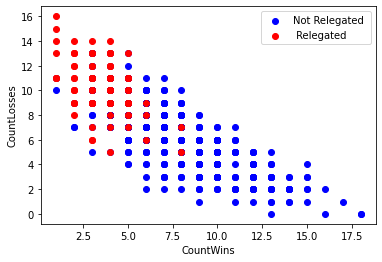

In [26]:

plt.scatter(FinalMergedDF[FinalMergedDF.Relegated==0]['CountWins'],FinalMergedDF[FinalMergedDF.Relegated==0]['CountLosses'],c='b', label="Not Relegated ") 
plt.scatter(FinalMergedDF[FinalMergedDF.Relegated==1]['CountWins'],FinalMergedDF[FinalMergedDF.Relegated==1]['CountLosses'],c='r',label=" Relegated ") 
plt.legend()
plt.xlabel('CountWins')
plt.ylabel('CountLosses')
plt.show()

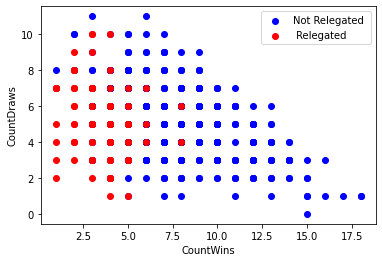

In [27]:
plt.scatter(FinalMergedDF[FinalMergedDF.Relegated==0]['CountWins'],FinalMergedDF[FinalMergedDF.Relegated==0]['CountDraws'],c='b', label="Not Relegated ") 
plt.scatter(FinalMergedDF[FinalMergedDF.Relegated==1]['CountWins'],FinalMergedDF[FinalMergedDF.Relegated==1]['CountDraws'],c='r',label=" Relegated ") 
plt.xlabel('CountWins')
plt.ylabel('CountDraws')
plt.legend()
plt.show()

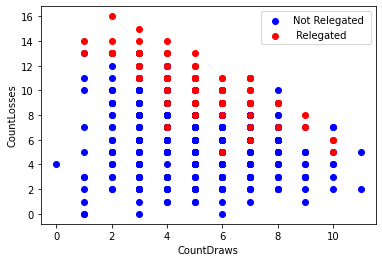

In [28]:
plt.scatter(FinalMergedDF[FinalMergedDF.Relegated==0]['CountDraws'],FinalMergedDF[FinalMergedDF.Relegated==0]['CountLosses'],c='b', label="Not Relegated ") 
plt.scatter(FinalMergedDF[FinalMergedDF.Relegated==1]['CountDraws'],FinalMergedDF[FinalMergedDF.Relegated==1]['CountLosses'],c='r',label=" Relegated ") 
plt.xlabel('CountDraws')
plt.ylabel('CountLosses')
plt.legend()
plt.show()

([<matplotlib.patches.Wedge at 0x26e77467be0>,
 [Text(0.9997951992431945, -1.9596962926867678, 'Not Relegated'),
  Text(-0.9997951992431947, 1.9596962926867676, 'Relegated')],
 [Text(0.7271237812677778, -1.4252336674085584, '85.0%'),
  Text(-0.727123781267778, 1.4252336674085582, '15.0%')])

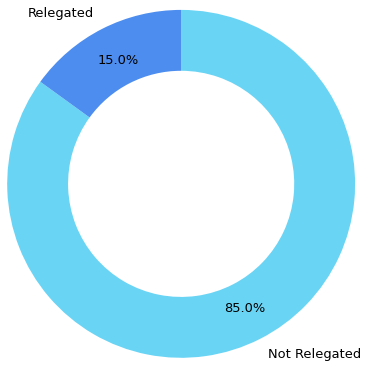

In [29]:
Relegated_count=FinalMergedDF['Relegated'].value_counts()
plt.pie(Relegated_count,labels=['Not Relegated','Relegated'],startangle=90,counterclock=False,wedgeprops = {'width' : 0.7},radius=2,autopct='%.1f%%',
        pctdistance=0.8,colors=['#6AD4F5','#4C8DEF'],textprops={'fontsize': 13})

# Machine Learning Models

In [30]:
def model_fit(x_train,y_train,x_test,y_test,MNB=1):
    models={'Logistic regression: ':LogisticRegression(max_iter=1000,random_state=39),
          'Decision Tree: ':tree.DecisionTreeClassifier(),
          'KNN: ':KNeighborsClassifier(n_neighbors=1),
          'SVM: ':SVC(),
          'Random Forest: ': RandomForestClassifier(),
           'XGBoost: ':XGBClassifier(use_label_encoder =False),
           'Multinomial Naive Bayes: ':MultinomialNB(),
           'Gaussian Naive Bayes: ': GaussianNB()}

    model_report={}
    for name,model in models.items():
        if name!='Multinomial Naive Bayes: ' or (name=='Multinomial Naive Bayes: ' and MNB):
            model.fit(x_train,y_train)
            y_pred=model.predict(x_test)
            model_report[name]= classification_report(y_test, y_pred)
    return model_report

## Before OverSampling

In [31]:
x=FinalMergedDF.drop('Relegated',axis=1)
y=FinalMergedDF['Relegated']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) 
model_report=model_fit(x_train,y_train,x_test,y_test)
for name,model in model_report.items():
    print(f'Model name:{name}\n{model}\n')

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\xgboost\data.py:

[19:41:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model name:Logistic regression: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.93       158
           1       0.59      0.42      0.49        24

    accuracy                           0.88       182
   macro avg       0.75      0.69      0.71       182
weighted avg       0.87      0.88      0.88       182


Model name:Decision Tree: 
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       158
           1       0.35      0.46      0.40        24

    accuracy                           0.82       182
   macro avg       0.63      0.67      0.65       182
weighted avg 

## After OverSampling

([<matplotlib.patches.Wedge at 0x26e7764da00>,
 [Text(2.2, 0.0, 'Not Relegated'),
  Text(-2.2, -2.6942229581241775e-16, 'Relegated')],
 [Text(1.6, 0.0, '50.0%'), Text(-1.6, -1.9594348786357652e-16, '50.0%')])

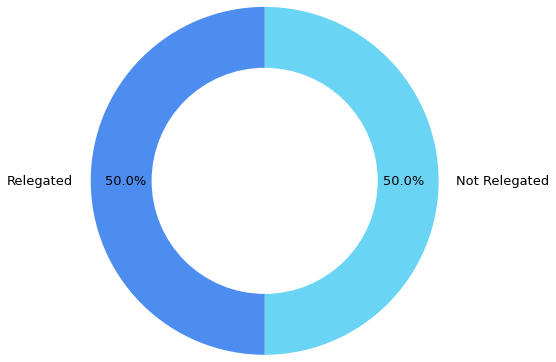

In [32]:
"""smote=SMOTE(sampling_strategy='minority')
x_train,y_train=smote.fit_resample(x_train,y_train)
Relegated_count=y_train.value_counts()
plt.pie(Relegated_count,labels=['Not Relegated','Relegated'],startangle=90,counterclock=False,wedgeprops = {'width' : 0.7},radius=2,autopct='%.1f%%',
        pctdistance=0.8,colors=['#6AD4F5','#4C8DEF'],textprops={'fontsize': 13})"""
Oversample=RandomOverSampler(sampling_strategy='minority')
x_train,y_train=Oversample.fit_resample(x_train,y_train)
Relegated_count=y_train.value_counts()
plt.pie(Relegated_count,labels=['Not Relegated','Relegated'],startangle=90,counterclock=False,wedgeprops = {'width' : 0.7},radius=2,autopct='%.1f%%',
        pctdistance=0.8,colors=['#6AD4F5','#4C8DEF'],textprops={'fontsize': 13})

In [33]:
model_report=model_fit(x_train,y_train,x_test,y_test)
for name,model in model_report.items():
    print(f'Model name:{name}\n{model}\n')

[19:41:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model name:Logistic regression: 
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       158
           1       0.40      0.92      0.56        24

    accuracy                           0.81       182
   macro avg       0.69      0.85      0.72       182
weighted avg       0.91      0.81      0.83       182


Model name:Decision Tree: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       158
           1       0.38      0.38      0.38        24

    accuracy                           0.84       182
   macro avg       0.64      0.64      0.64       182
weighted avg 

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## After OverSampling and Standardization

In [34]:
FinalMergedDF_copy=FinalMergedDF.copy(deep=True)
s = StandardScaler()
FinalMergedDF_copy[['CountWins', 'CountLosses', 'CountDraws']] = s.fit_transform(FinalMergedDF_copy[['CountWins', 'CountLosses', 'CountDraws']])
x_copy=FinalMergedDF_copy.drop('Relegated',axis=1)
y_copy=FinalMergedDF_copy['Relegated']
smote=SMOTE(sampling_strategy='minority')
x_train, x_test, y_train, y_test = train_test_split(x_copy, y_copy, test_size=0.3, random_state=42)
x_train,y_train=smote.fit_resample(x_train,y_train)

In [35]:
model_report=model_fit(x_train,y_train,x_test,y_test,0)
for name,model in model_report.items():
    print(f'Model name:{name}\n{model}\n')

[19:41:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model name:Logistic regression: 
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       158
           1       0.40      0.88      0.55        24

    accuracy                           0.81       182
   macro avg       0.69      0.84      0.72       182
weighted avg       0.90      0.81      0.84       182


Model name:Decision Tree: 
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       158
           1       0.28      0.38      0.32        24

    accuracy                           0.79       182
   macro avg       0.59      0.61      0.60       182
weighted avg 

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
